In [1]:
from process_covidtracking import GetData, ExtractDataFrame
import datetime
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
pd.plotting.register_matplotlib_converters()

In [2]:
start_date = datetime.date(2020,3,15)
df, locs = ExtractDataFrame(GetData('./', start_date), start_date)

df.head()

,,cum_positive,cum_total,curr_hosp,cum_hosp,curr_icu,cum_icu,curr_vent,cum_vent,cum_death,new_death,new_cases
state,date,,,,,,,,,,,
AK,2020-03-15,1.0,144,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0
AL,2020-03-15,12.0,86,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0
AR,2020-03-15,16.0,149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
AZ,2020-03-15,12.0,183,NaN,36.0,NaN,NaN,NaN,NaN,0.0,0,0.0
CA,2020-03-15,293.0,1209,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0,0.0


In [3]:
def FormatPlot():
    ymin, ymax = plt.ylim()
    label_days = []
    for month in range(2,9):
        plt.plot([datetime.date(2020,month,1),datetime.date(2020,month,1)],[ymin,ymax],'--k')
        for day in [1,15]:
            label_days.append(datetime.date(2020,month,day))
    plt.xticks(label_days, rotation=25,fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(datetime.date(2020,3,1), datetime.date(2020,8,1))
    plt.ylim(0,ymax)

    

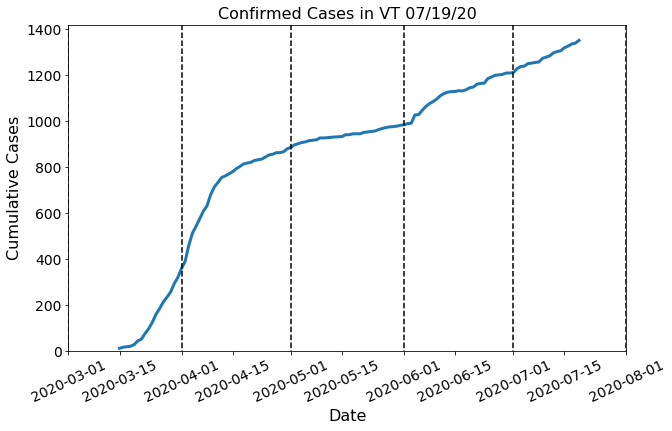

In [4]:
state = 'VT'

plt.figure(figsize=(10,6))
plt.plot(df.loc[state]['cum_positive'], linewidth=3)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative Cases', fontsize=16)
plt.title('Confirmed Cases in ' + state + ' ' + df.loc[state].index[-1].strftime("%m/%d/%y"), fontsize=16)

FormatPlot()
plt.savefig('CumulativeCases_'+state +'.png')
plt.show()

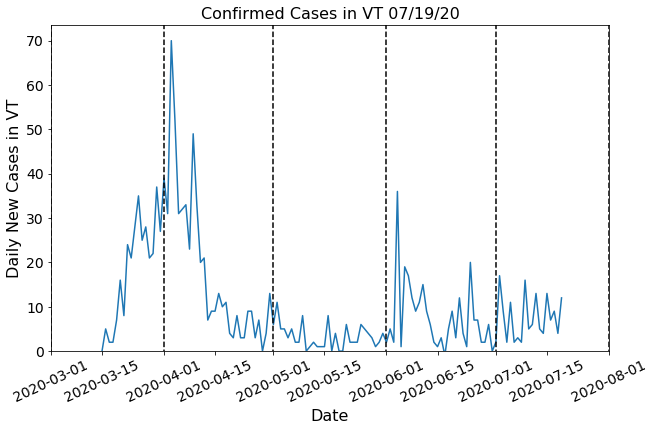

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df.loc[state]['new_cases'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily New Cases in ' + state, fontsize=16)
plt.title('Confirmed Cases in ' + state + ' ' + df.loc[state].index[-1].strftime("%m/%d/%y"), fontsize=16)


FormatPlot()
plt.savefig('NewCases_'+state +'.png')
plt.show()

In [6]:
upper_R0 = 6.0
lower_R0 = 0.5

prior_mean =  0.5*(np.log(upper_R0) + np.log(lower_R0))
prior_var = 0.25*(np.log(upper_R0) - np.log(lower_R0))


In [7]:
def LognormalPDF(r0, mean, var):

    log_r0 = np.log(r0)
    return np.exp(-(0.5/var)*(log_r0-mean)**2)/(r0*np.sqrt(2.0*np.pi*var))


In [8]:
r0s = np.linspace(0.1,6.0,100)
prior_pdf = LognormalPDF(r0s, prior_mean, prior_var)

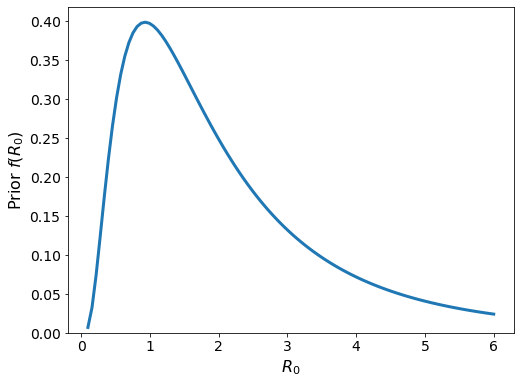

In [9]:
plt.figure(figsize=(8,6))

plt.plot(r0s,prior_pdf, linewidth=3)

ymin, ymax = plt.ylim()
plt.ylim(0,ymax)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$R_0$', fontsize=16)
plt.ylabel('Prior $f(R_0)$', fontsize=16)
plt.savefig('PriorPDF.png')
plt.show()

In [10]:
def ComputePost(prior_mean, prior_var, obs_val, obs_var):
    """ Computes the posterior mean and variance 
        given an observation with value obs_val 
        and variance obs_var. 
    """
    post_var = obs_var*prior_var / (prior_var + obs_var)
    post_mean = post_var *(obs_val/obs_var + prior_mean/prior_var)
    
    return post_mean, post_var

def EvolveDist(prior_mean, prior_var, dynamics_var):
    return prior_mean, prior_var + dynamics_var

In [11]:
T = 8
dynamics_var = 0.2**2
obs_var = 2.0**2


In [12]:
curr_mean = np.copy(prior_mean)
curr_var = np.copy(prior_var)

num_days = df.loc[state].shape[0]-T

obs_vals = np.zeros(num_days) # holds the difference in log of the new values
log_r0_mean = np.zeros(num_days)
log_r0_var = np.zeros(num_days)

for day_ind in range(num_days):
    if((df.loc[state]['new_cases'].iloc[day_ind+T]>0)&(df.loc[state]['new_cases'].iloc[day_ind]>0)):

        obs_vals[day_ind] = (np.log(df.loc[state]['new_cases'].iloc[day_ind+T])-np.log(df.loc[state]['new_cases'].iloc[day_ind]))

        post_mean, post_var = ComputePost(curr_mean, curr_var, obs_vals[day_ind], obs_var)

        log_r0_mean[day_ind] = post_mean
        log_r0_var[day_ind] = post_var
    
        curr_mean, curr_var = EvolveDist(post_mean, post_var, dynamics_var)
    else:
        log_r0_mean[day_ind] = curr_mean
        log_r0_var[day_ind] = curr_var
        curr_mean, curr_var = EvolveDist(curr_mean, curr_var, dynamics_var)
        

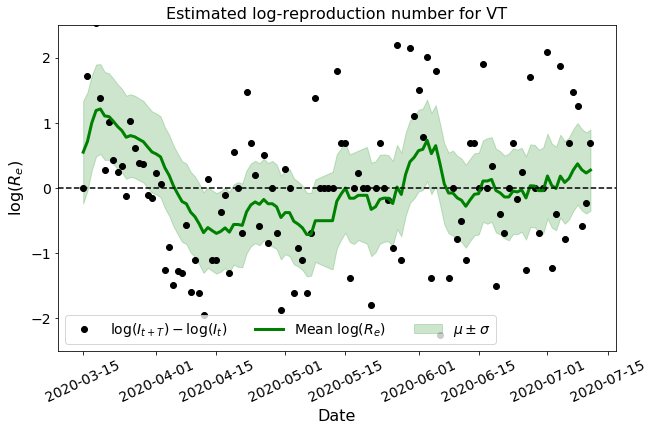

In [13]:
dates = df.loc[state]['new_cases'].iloc[0:-T].index


plt.figure(figsize=(10,6))

plt.plot(dates,obs_vals,'ok',label='$\log(I_{t+T}) - \log(I_{t})$')

plt.fill_between(dates,log_r0_mean-np.sqrt(log_r0_var), log_r0_mean+np.sqrt(log_r0_var), color='g', alpha=0.2, label='$\mu\pm\sigma$')

plt.plot(dates,log_r0_mean, '-g', linewidth=3, label='Mean $\log(R_e)$')

plt.legend(fontsize=14, ncol=3)
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax],[0,0],'--k')

ymin, ymax = plt.ylim()
label_days = []
for month in range(2,9):
    for day in [1,15]:
        label_days.append(datetime.date(2020,month,day))

plt.xticks(label_days, rotation=25,fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin,xmax)

plt.title('Estimated log-reproduction number for ' + state, fontsize=16)
plt.ylabel('$\log(R_e)$', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylim(-2.5,2.5)

plt.savefig('Posterior_LogScale_' + state +'.png')
plt.show()

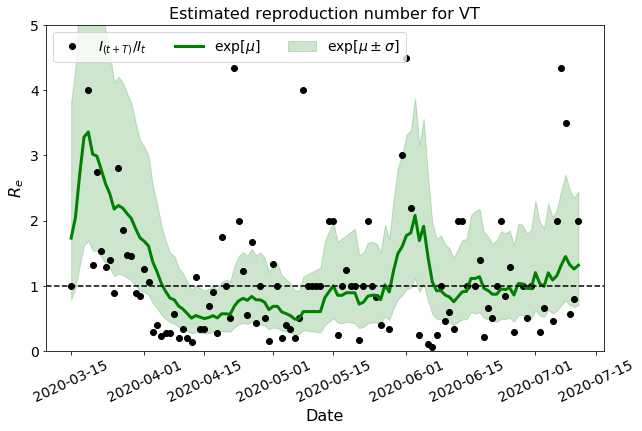

In [14]:

dates = df.loc[state]['new_cases'].iloc[0:-T].index


plt.figure(figsize=(10,6))

plt.plot(dates,np.exp(obs_vals),'ok',label='$I_{(t+T)}/I_{t}$')

plt.fill_between(dates,np.exp(log_r0_mean-np.sqrt(log_r0_var)), np.exp(log_r0_mean+np.sqrt(log_r0_var)), color='g', alpha=0.2, label='$\exp[\mu\pm\sigma]$')

plt.plot(dates,np.exp(log_r0_mean), '-g', linewidth=3, label='$\exp[\mu]$')

plt.legend(fontsize=14, ncol=3)
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax],[1,1],'--k')

ymin, ymax = plt.ylim()
label_days = []
for month in range(2,9):
    for day in [1,15]:
        label_days.append(datetime.date(2020,month,day))

plt.xticks(label_days, rotation=25,fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin,xmax)

plt.title('Estimated reproduction number for ' + state, fontsize=16)
plt.ylabel('$R_e$', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylim([0,5])

plt.savefig('Posterior_' + state +'.png')
plt.show()